In [50]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform

# Classifiers:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Load data, reshape X, and split into training, testing and validation data

In [51]:
y = np.load('MNIST-labels.npy')
X = np.load('MNIST-images.npy')

X = np.where(X<175,0,X) # replace noise in data with 0,
X= X.reshape(X.shape[0], 576) #transform to vector

X_train,X_test_val,y_train,y_test_val = train_test_split(X, y, test_size=0.3, random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state = 42)

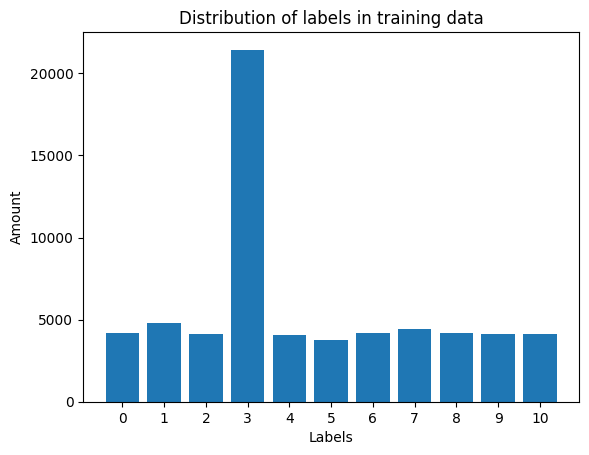

In [52]:
#create two different dataframe of majority and minority class 
# X_majority = X_train[(y_train==3)] 
X_minority = X_train[(y_train==8)] 



X_remaining = X_train[(y_train!=8)]
y_remaining = y_train[(y_train!=8)]
# average_amount = len(y_remaining)//10
# X_majority_downsampled = resample(X_majority, replace=True, n_samples= average_amount, random_state=42) 
# y_majority_downsampled = np.full(X_majority_downsampled.shape[0],3,dtype='int64')

# X_remaining = X_train[(y_train!=8)]
# y_remaining = y_train[(y_train!=8)]

average_amount = len(y_remaining[(y_remaining!=3)])//9 # We create this so we can resample to the average amount of occorences of labels
X_minority_upsampled = resample(X_minority, replace=True, n_samples= average_amount, random_state=42) 
y_minority_upsampled = np.full(X_minority_upsampled.shape[0],8,dtype='int64')

# X_train= np.concatenate([X_remaining, X_minority_upsampled,X_majority_downsampled])
# y_train= np.concatenate([y_remaining, y_minority_upsampled,y_majority_downsampled])

X_train= np.concatenate([X_remaining, X_minority_upsampled])
y_train= np.concatenate([y_remaining, y_minority_upsampled])

rg = np.arange(0,11)
labels = pd.DataFrame(y_train).value_counts().sort_index().values
fig = plt.figure()
plt.xticks(rg)
plt.bar(rg,labels) # Using bar because histogram combined columns 9 and 10
plt.title('Distribution of labels in training data')
plt.xlabel('Labels')
plt.ylabel('Amount')
plt.show()

In [53]:
# Centering the dataset, this is needed for PCA
X_val = X_val-X_train.mean()
X_test = X_test-X_train.mean()
X_train = X_train-X_train.mean()
pca = PCA(n_components=35)
pca.fit(X_train) # Have to fit on training data to avoid learning test/val data
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)


# This is made to keep track of the candidate models, and to choose one at the end
potential_models = pd.DataFrame(columns=['Classifier name','Accuracy score','Balanced accuracy score','Classifier object'])

Resample

Useful functions

In [54]:
# plots the confusion matrix of a classifier with its name and precision score
def plot_c_matrix_val_data(clf, classifier_name,balanced_accuracy):
    disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_val,
            y_val,
            display_labels=np.arange(0,11),
            cmap=plt.cm.Blues,
            include_values = False,
            normalize='true',
        )
    disp.ax_.set_title("Confusion matrix for " + str(classifier_name) + " on validation data")
    plt.text(-6, 1, f'Balanced acc: {str(round(balanced_accuracy,3))}', backgroundcolor = 'orange', fontsize = 10)
    plt.show()

# Fits the model and makes a prediction on validation data.
# Returns a dataframe containing relevant information about the classifier
def evaluate_classifier(clf,classifier_name):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val,y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_val,y_pred)

    current_accuracy_dict = {
    'Classifier name' : [classifier_name],
    'Accuracy score' : [accuracy],
    'Balanced accuracy score' : [balanced_accuracy],
    'Classifier object' : [clf]
    }
    current_accuracy_df = pd.DataFrame(current_accuracy_dict)
    return current_accuracy_df, balanced_accuracy

Decision tree classifier:

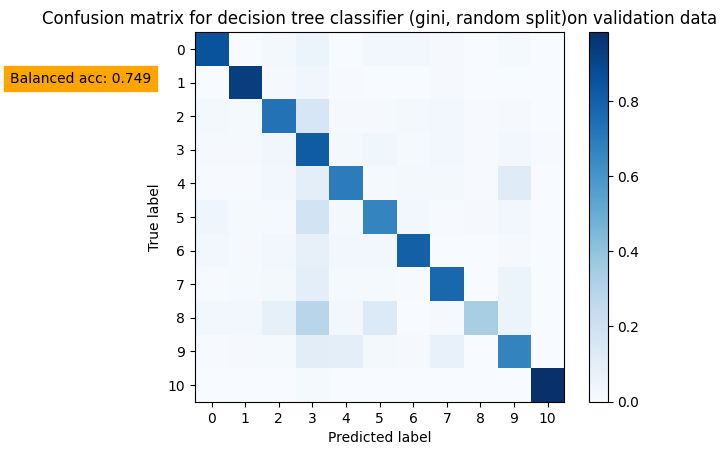

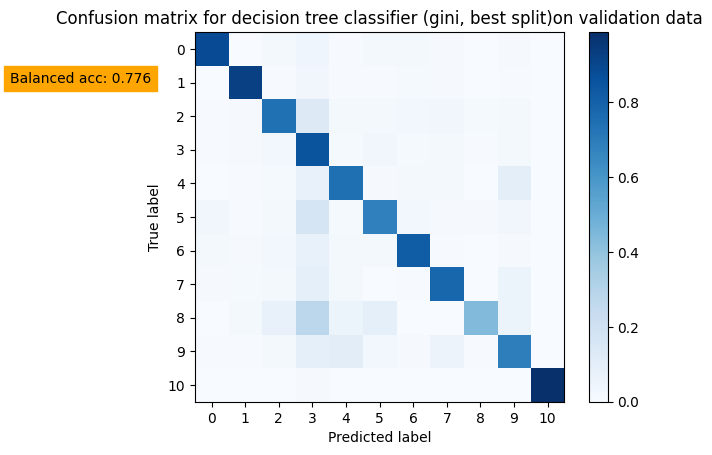

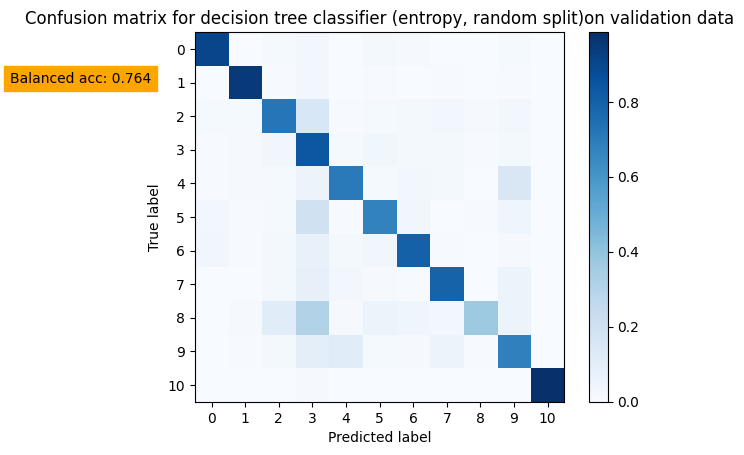

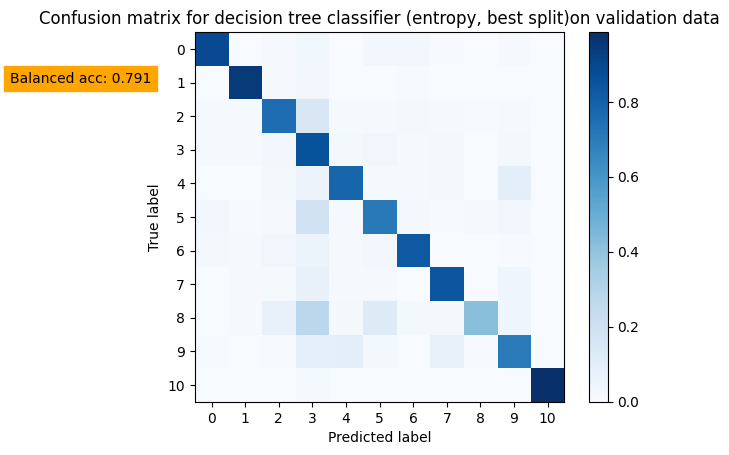

In [55]:
def dtc_evaluator(dtc, name, potential_models):
    dtc_df, balanced_accuracy = evaluate_classifier(dtc,name)
    plot_c_matrix_val_data(dtc,name,balanced_accuracy)
    return dtc_df

dtc_rg, name_rg  = DecisionTreeClassifier(splitter='random', random_state=1), 'decision tree classifier (gini, random split)'
dtc_bg, name_bg  = DecisionTreeClassifier(splitter='best', random_state=1), 'decision tree classifier (gini, best split)'
dtc_re, name_re  = DecisionTreeClassifier(splitter='random', criterion='entropy', random_state=1), 'decision tree classifier (entropy, random split)'
dtc_be, name_be  = DecisionTreeClassifier(splitter='best', criterion='entropy', random_state=1), 'decision tree classifier (entropy, best split)'

dtc_df = dtc_evaluator(dtc_rg,name_rg,potential_models) # random split + gini
potential_models = pd.concat([potential_models, dtc_df],ignore_index=True)
dtc_df =dtc_evaluator(dtc_bg,name_bg,potential_models) # best split + gini
potential_models = pd.concat([potential_models, dtc_df],ignore_index=True)
dtc_df = dtc_evaluator(dtc_re,name_re,potential_models) # random split + entropy
potential_models = pd.concat([potential_models, dtc_df],ignore_index=True)
dtc_df = dtc_evaluator(dtc_be,name_be,potential_models) # best split + entropy
potential_models = pd.concat([potential_models, dtc_df],ignore_index=True)

K nearest neighbors:

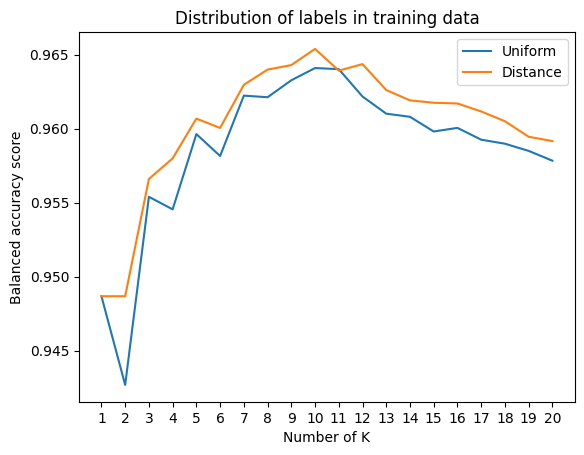

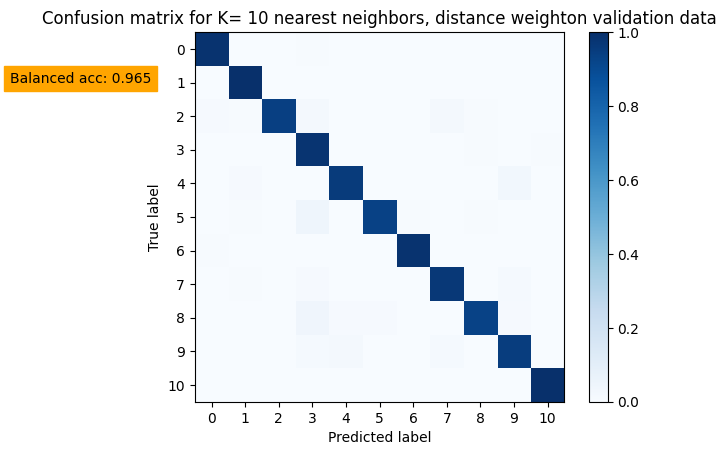

In [56]:
ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ks = np.arange(1,21)

neighbour_scores_uniform = []
neighbour_scores_distance = []

best_knn = (0,0,0)

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    name = f'K= {k} nearest neighbors, uniform weight'
    knn_df, balanced_accuracy = evaluate_classifier(knn, name)
    potential_models = pd.concat([potential_models,knn_df],ignore_index=True)
    if all(score < balanced_accuracy for score in neighbour_scores_uniform) and all(score < balanced_accuracy for score in neighbour_scores_distance):
        best_model = knn, name, balanced_accuracy
    neighbour_scores_uniform.append(balanced_accuracy)

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    name = f'K= {k} nearest neighbors, distance weight'
    knn_df, balanced_accuracy = evaluate_classifier(knn, name)
    potential_models = pd.concat([potential_models,knn_df],ignore_index=True)
    if all(score < balanced_accuracy for score in neighbour_scores_uniform) and all(score < balanced_accuracy for score in neighbour_scores_distance):
        best_model = knn, name, balanced_accuracy
    neighbour_scores_distance.append(balanced_accuracy)
    
x_values = [str(k) for k in ks]
fig = plt.figure()
plt.xticks(ticks=np.arange(0,len(x_values)),labels=x_values)
plt.plot(x_values,neighbour_scores_uniform)
plt.plot(x_values,neighbour_scores_distance)
plt.title('Distribution of labels in training data')
plt.xlabel('Number of K')
plt.ylabel('Balanced accuracy score')
plt.legend(labels=['Uniform','Distance'])
plt.show()

plot_c_matrix_val_data(best_model[0],best_model[1],best_model[2])

In [57]:
kernels = ['rbf','linear', 'poly', 'rbf', 'sigmoid']

distributions = dict(C=uniform(loc=0, scale=4),kernel=kernels, class_weight=['balanced',None],random_state=[1])
distributions = dict(C=[1],kernel=kernels, class_weight=['balanced',None],random_state=[1])
svm = SVC()
clf = RandomizedSearchCV(svm, distributions, random_state=0,scoring='balanced_accuracy')
search = clf.fit(X_train, y_train)
svm_df, balanced_accuracy = evaluate_classifier(search,'SVM')
potential_models = pd.concat([potential_models,svm_df],ignore_index=True)

In [ ]:
def plot_c_matrix_test_data(clf, classifier_name,balanced_accuracy):
    disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            display_labels=np.arange(0,11),
            cmap=plt.cm.Blues,
            include_values = False,
            normalize='true',
        )
    disp.ax_.set_title("Confusion matrix for " + str(classifier_name) + "on test data")
    plt.text(-6, 1, f'Balanced acc: {str(round(balanced_accuracy,3))}', backgroundcolor = 'orange', fontsize = 10)
    plt.show()

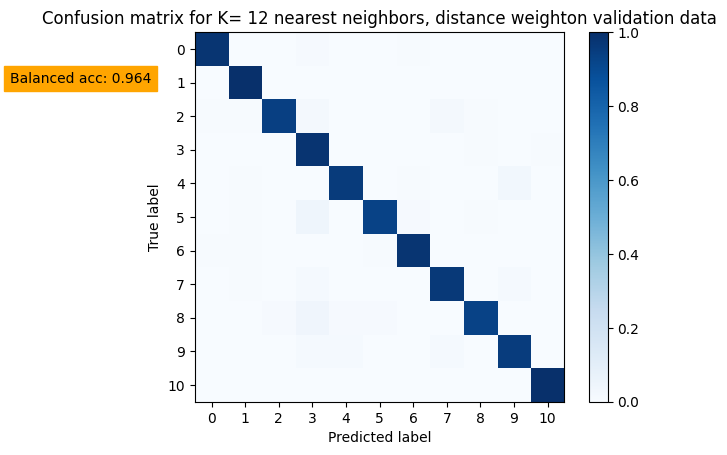

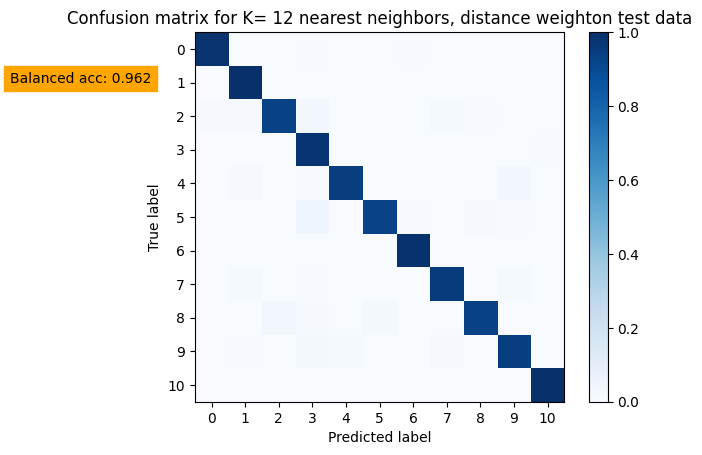

In [ ]:
potential_models = potential_models.sort_values(by="Balanced accuracy score", ascending=False)
best_model = potential_models.iloc[0,:] # finds the classifier on the first row, the one with highest accuracy score

plot_c_matrix_val_data(best_model['Classifier object'],best_model['Classifier name'],best_model['Balanced accuracy score'])

y_pred = best_model['Classifier object'].predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test,y_pred)
plot_c_matrix_test_data(best_model['Classifier object'],best_model['Classifier name'],balanced_accuracy)